# Векторные репрезентации слов
# Часть 1. Мешок слов (bag-of-words)
![bow](https://gurus.pyimagesearch.com/wp-content/uploads/2015/09/bovw_image_example.jpg)
<center>Picture from *CS4670/5670: Computer Vision*</center>
## Оглавление
* Обзор корпуса
* Частотные матрицы
* Коллокации 
* Взвешивание элементов частотных матриц


In [1]:
# Задействование всех ядер
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import operator
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.mpl_style', 'default')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

from matplotlib import rc
font = {'family': 'Verdana', 'weight': 'normal'}
rc('font', **font)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import nltk
from gensim.models.phrases import Phrases
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

## Загрузка данных
Корпус документов доступен по [ссылке](https://drive.google.com/open?id=0B_NefGKQ1pCsbDNMZ2N6WHFHUlE)

In [4]:
path_data = '~/'
file = path_data + 'corpora_lem.csv' # корпус

arxiv_id = pd.read_csv(path_data + 'corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


In [5]:
class LazyCorpora:
    def __init__(self, file, column, n, reduce=1, split=False):
        self.column = column
        self.file = file
        self.n = n
        self.reduce = reduce
        self.split = split
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0].split()
            #
            # фильтруем токены
            cleaned = [token for token in content if token[0] in 'abcdefghijklmnopqrstuvwxyz']
            #
            # игнорируем документы, которые состоят более чем из 15000 слов
            condition = len(cleaned) < 15000 and i%self.reduce == 0
            if self.column == 'text' and condition:
                if not self.split:
                    yield ' '.join(cleaned)
                else:
                    yield cleaned
            elif condition:
                data = row[self.column].values[0]
                yield data

In [6]:
corpora = LazyCorpora(file, 'text', n_corpora, reduce=1)
print(corpora)

Фрагмент документа корпуса

In [7]:
for doc in corpora:
    print(doc[:1000])
    break

the goal of this paper be to construct invariant dynamical object for not necessarily invertible smooth self map of compact manifold we prove result that take advantage of difference in rat of expansion in the term of sheaf cohomological long exact sequence to create unique lift of finite dimensional invariant subspace of one term of the sequence to invariant subspace of the precede term this allow to take invariant cohomological class and under the right circumstance construct unique current of give type include unique measure of give type that represent those class and be invariant under pullback dynamically interest self map may have plethora of invariant measure so the uniquess of the construct current be important it mean that if local growth be not too big compare to the growth rate of the cohomological class then the expand cohomological class give sufficient march order of any other such invariant current of the same type say from some local dynamical subsystem because we use s

## Сериализация объектов

In [8]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Обзор корпуса

In [9]:
def bow_with_freq(corpora):
    result = Counter()
    for s in corpora:
        result.update(s.split())
    return list(result.items())

Для каждого токена определим сколько раз он встречается в корпусе

In [10]:
%%time

bow = bow_with_freq(corpora)
token_counts = pd.DataFrame(bow, columns=['token', 'count'])
sorted_tokens = token_counts.sort('count', ascending=False).set_index('token')

CPU times: user 15min 37s, sys: 4.8 s, total: 15min 41s
Wall time: 17min 11s


50 наиболее популярных слов

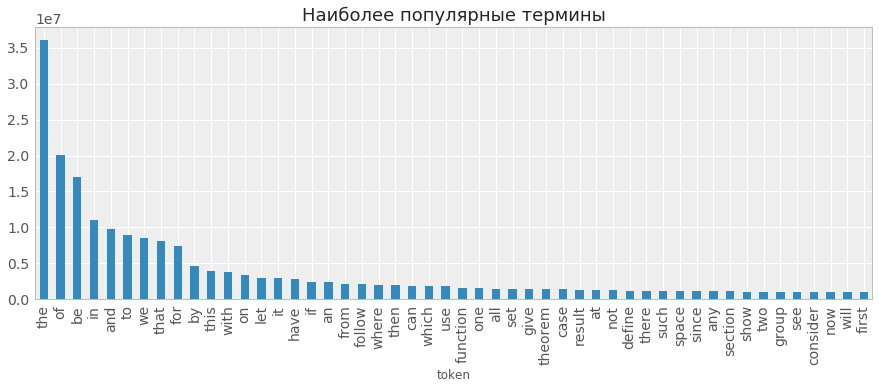

In [11]:
plt.title("Наиболее популярные термины", fontsize=18)
sorted_tokens['count'][:50].plot(kind='bar')
plt.show()

Как можно заметить, наиболее часто встречаются функциональные слова: предлоги, союзы, местоимения. Эти термины не несут смысловой нагрузки и от них не зависит тематика тескта. Такие слова называют [стоп-словами](http://xpo6.com/list-of-english-stop-words/) и их часто при векторизации игнорируют, считая шумом.

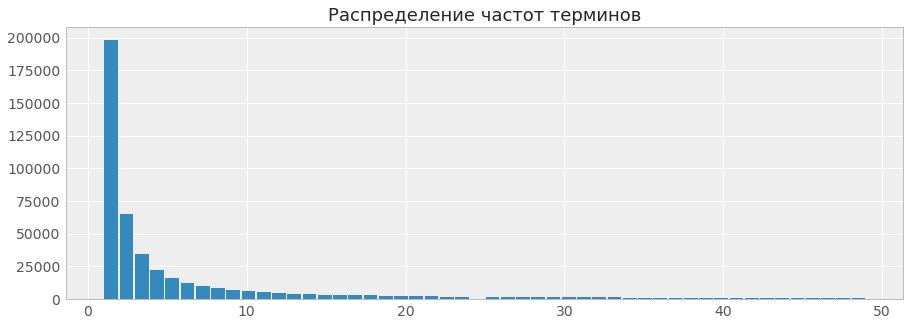

In [12]:
plt.title("Распределение частот терминов", fontsize=18)
mask = sorted_tokens['count'] < 50
plt.hist(sorted_tokens[mask]['count'], bins=50, rwidth=0.9)
plt.show()

Большинство слов -- это редкие слова, т.е. уникальные леммы, которые встречаются в корпусе всего несколько раз

Примеры редких слов

In [13]:
sorted_tokens[sorted_tokens['count'] < 2].head(10)

,count
token,
dinmension,1
nehveyev,1
autodualit,1
cylotomy,1
skigranov,1
autoregresssive,1
lexicograhical,1
cordialement,1
anaylytically,1


Здесь встречаются и редкие английские слова, опечатки, лексика других языков и др.

### Закон Ципфа  

**Закон Ципфа** [wiki]  -- эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (так называемому рангу этого слова). Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье  в три раза реже, чем первое, и так далее.  

Проверим выполняется ли закон Ципфа на примере 200 наиболее употребляемых слов корпуса.

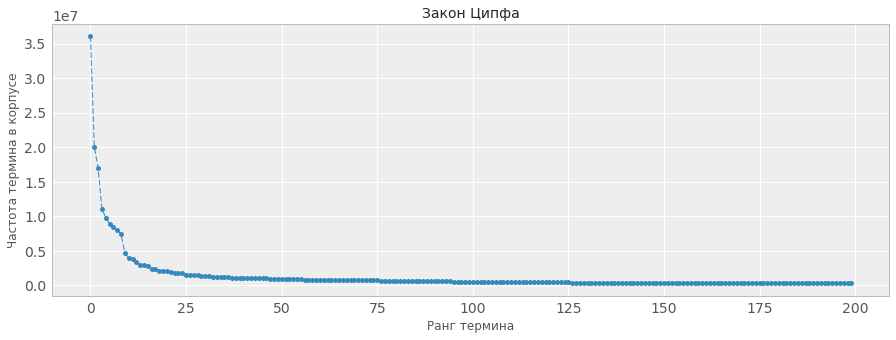

In [27]:
freq = sorted(list(set(sorted_tokens['count'].values)), reverse=True)
plt.title("Закон Ципфа", fontsize=14)
plt.xlabel("Ранг термина")
plt.ylabel("Частота термина в корпусе")
plt.plot(range(200), freq[:200], 'o--', markersize=5);

Замечаем, что полученный график не идеальная гипербола, но похоже, что закон работает. Теперь удалим стоп-слова и посмотрим сгладится ли левая часть графика.

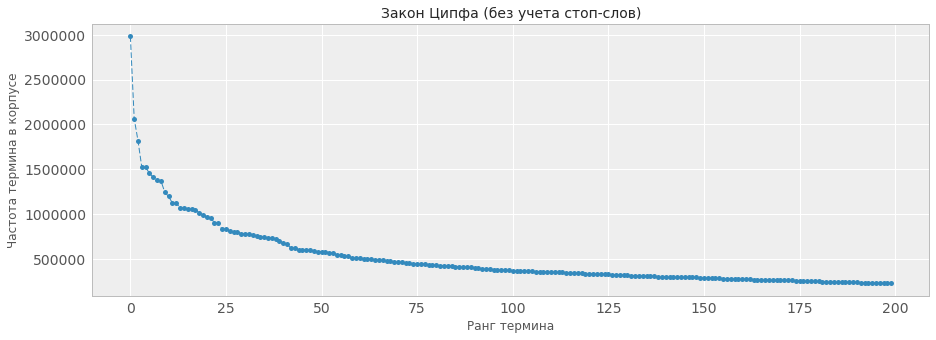

In [30]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

freq = sorted_tokens[~sorted_tokens.index.isin(stop)]['count']
plt.title("Закон Ципфа (без учета стоп-слов)", fontsize=14)
plt.xlabel("Ранг термина")
plt.ylabel("Частота термина в корпусе")
plt.plot(range(200), freq[:200], 'o--', markersize=5);

### Статистика корпуса

In [31]:
print("Количесво документов в корпусе: %d" % n_corpora)
print("Количесво токенов в корпусе: %d" % sorted_tokens.sum())
print("Количесво уникальных лемм в корпусе: %d" % sorted_tokens.count())
print("Средний размер документа (количество токенов): %d" % int(sorted_tokens.sum() / n_corpora))
print("Среднее количесво уникальных лемм в документе: %d" % int(sorted_tokens.count() / n_corpora))

Количесво документов в корпусе: 164197
Количесво токенов в корпусе: 428228862
Количесво уникальных лемм в корпусе: 490047
Средний размер документа (количество токенов): 2608
Среднее количесво уникальных лемм в документе: 2


#### Размер статей

In [32]:
doc_len = pd.Series([len(doc.split()) for doc in corpora])

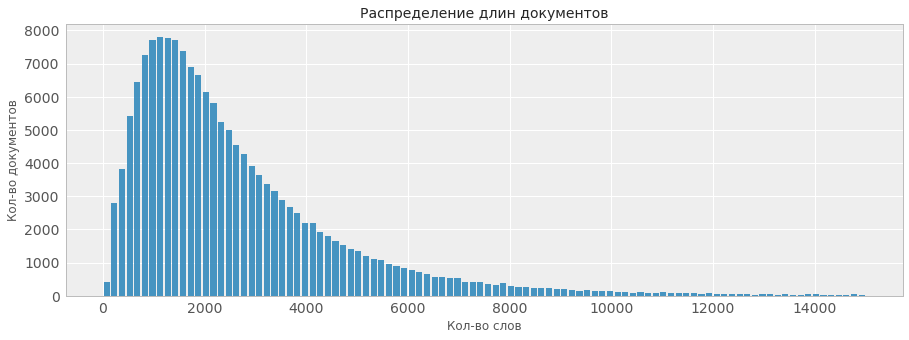

In [33]:
plt.title("Распределение длин документов", fontsize=14)
plt.hist(doc_len, bins=100, alpha=0.9, rwidth=0.8)
plt.xlabel('Кол-во слов')
plt.ylabel('Кол-во документов')
plt.show()

Отметим, что распределение похоже на [логнормальное](https://ru.wikipedia.org/wiki/Логнормальное_распределение)

### Категории

#### Главные категории

In [34]:
lazy_category = LazyCorpora(file, 'primary_category', n_corpora, reduce=1)
primary_category = pd.Series([c for c in lazy_category])

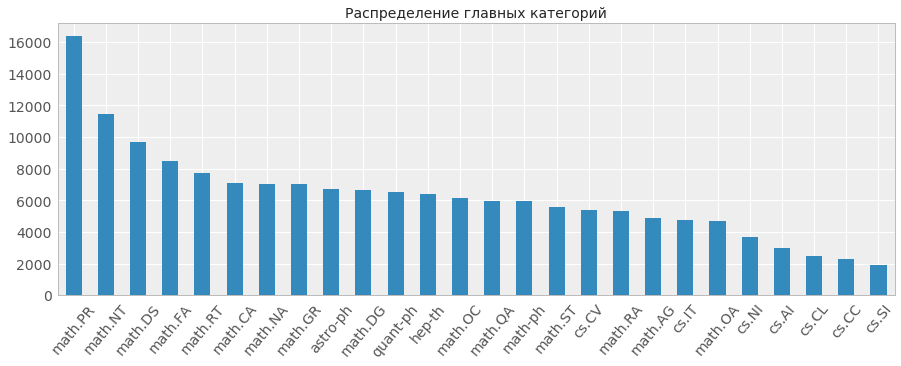

Количество категорий: 26
Среднее количество статей в категории: 6040
Медиана: 5932


In [43]:
category_counts = primary_category.value_counts()
category_counts[:-1].plot(kind='bar', rot=50)
plt.title("Распределение главных категорий", fontsize=14)
plt.show()
print('Количество категорий: %d' % (primary_category.nunique() - 1))
print('Среднее количество статей в категории: %d' % int(np.mean(category_counts)))
print('Медиана: %d' % int(np.median(category_counts)))

#### Все категории

In [36]:
lazy_cat = LazyCorpora(file, 'categories', n_corpora)
categories = [c for c in lazy_cat]

In [37]:
cat_list = []
for cat in categories:
    cat_list += eval(cat)

categories_flat = [c for c in cat_list if '[' not in c]
categories_df = pd.Series(categories_flat)

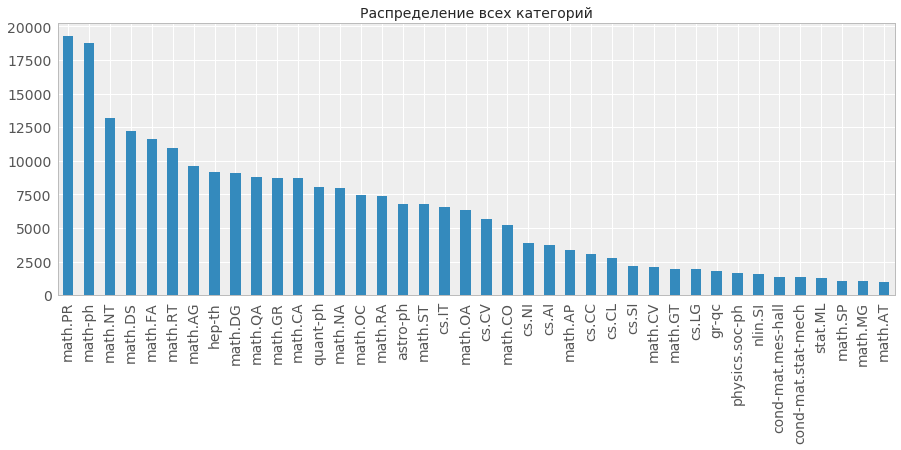

Количество категорий: 83
Среднее количество статей в категории: 6131
Медиана: 6003


In [38]:
category_counts = categories_df.value_counts()[:40]
category_counts.plot(kind='bar')
plt.title("Распределение всех категорий", fontsize=14)
plt.show()
print('Количество категорий: %d' % categories_df.nunique())
print('Среднее количество статей в категории: %d' % int(np.mean(category_counts)))
print('Медиана: %d' % int(np.median(category_counts)))

#### К какому количеству тем отосятся документы

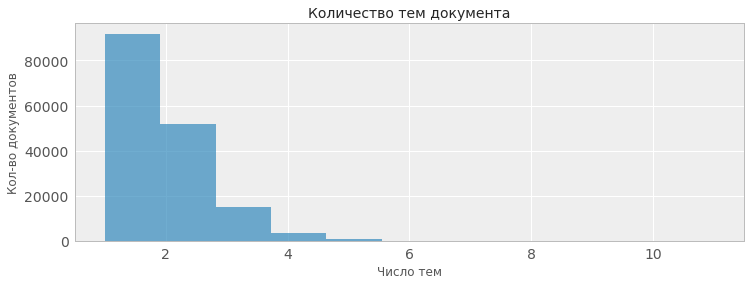

Максимальное число тем: 11
Минимальное число тем: 1
Среднее число тем: 1.586
Медиана тем: 1.000


In [39]:
freq = [cat.count(',') + 1 for cat in categories]

plt.figure(figsize=(12,4))
plt.title("Количество тем документа", fontsize=14)
plt.hist(freq, alpha=0.7, bins=11)
plt.xlabel('Число тем')
plt.ylabel('Кол-во документов')
plt.show()

print("Максимальное число тем: %d" % max(freq))
print("Минимальное число тем: %d" % min(freq))
print("Среднее число тем: %.3f" % np.mean(freq))
print("Медиана тем: %.3f" % np.median(freq))

Большая часть документов имеет одну тему, поэтому будем предсказывать только главную категорию 

## Частотная матрица термины-документы
[Описание]

In [7]:
#tokenizer = nltk.word_tokenize
pattern = '[a-z0-9]+'

In [31]:
%time

vect = CountVectorizer(token_pattern=pattern, lowercase=False)
vect.fit(corpora)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='[a-z0-9]+', tokenizer=None,
        vocabulary=None)

In [32]:
print("Размер словаря: %d" % len(vect.vocabulary_))

Размер словаря: 478739


Преобразовав корпус, получим разреженную матрицу размера n x m, где n -- количество документов в корпусе, а m -- размер словаря.  

Выведем 100 последних словарных слов

In [33]:
print(vect.get_feature_names()[-100:])

['zylberach', 'zylberajch', 'zylinder', 'zylindersymmetrischer', 'zyliu', 'zylka', 'zylman', 'zylstra', 'zymler', 'zymnis', 'zymogen', 'zymonopoulou', 'zymund', 'zyn', 'zynga', 'zynq', 'zypchen', 'zypmann', 'zyren', 'zyserman', 'zyskin', 'zyskind', 'zysno', 'zyt', 'zytkov', 'zytkow', 'zytnicki', 'zyuganov', 'zyung', 'zyuzin', 'zyvagin', 'zyw', 'zywina', 'zywyzywyzywy', 'zywzywzyw', 'zyx', 'zyxel', 'zyxz', 'zyxzy', 'zyxzyxzyx', 'zyy', 'zyz', 'zyzx', 'zyzxzyzxzyzx', 'zyzyzy', 'zyzzyva', 'zz', 'zza', 'zzalb', 'zzb', 'zzc', 'zzdc', 'zzf', 'zzh', 'zzhang', 'zzhou', 'zzi', 'zzii', 'zzisjo', 'zziz', 'zzizi', 'zzjgjg', 'zzk', 'zzkarian', 'zzl', 'zzm', 'zzo', 'zzp', 'zzps', 'zzquy', 'zzremi', 'zzril', 'zzrr', 'zzrtoqobf', 'zzs', 'zzsr', 'zzu', 'zzwang', 'zzwc', 'zzwz', 'zzx', 'zzy', 'zzz', 'zzzap', 'zzzchen', 'zzzhangzhiyuan', 'zzzhhc', 'zzzingers', 'zzzucchini', 'zzzz', 'zzzzipppp', 'zzzzzzzz', 'zzzzzzzzz', 'zzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

### Сокращение словаря  
* Исключение редких слов
* Удаление стоп-слов


[Обоснование]

In [34]:
%%time

vect = CountVectorizer(token_pattern=pattern, lowercase=False, min_df=20, stop_words='english')
vect.fit(corpora)

CPU times: user 10min 35s, sys: 3.16 s, total: 10min 38s
Wall time: 10min 38s


In [35]:
print("Размер сокращенного словаря: %d" % len(vect.vocabulary_))

Размер сокращенного словаря: 54475


In [36]:
print(vect.get_feature_names()[-100:])

['zonal', 'zone', 'zong', 'zonoid', 'zonoids', 'zonotope', 'zonotopes', 'zoo', 'zoology', 'zoom', 'zoran', 'zorich', 'zorin', 'zorn', 'zorzi', 'zotov', 'zotti', 'zou', 'zoupanos', 'zout', 'zowe', 'zp', 'zq', 'zquez', 'zr', 'zrp', 'zsid', 'zsido', 'zsigmondy', 'zt', 'zu', 'zuazua', 'zubairy', 'zuber', 'zubkov', 'zucca', 'zucchini', 'zucker', 'zuckerman', 'zudilin', 'zueinander', 'zugeh', 'zuk', 'zukowski', 'zum', 'zumino', 'zun', 'zung', 'zuniga', 'zunino', 'zuo', 'zupnik', 'zur', 'zurek', 'zurich', 'zusammen', 'zusammenh', 'zusammenhang', 'zuse', 'zusmanovich', 'zuyev', 'zv', 'zvavitch', 'zvenigorod', 'zvi', 'zvonkin', 'zvonkine', 'zw', 'zwaan', 'zwanzig', 'zwanziger', 'zwara', 'zwart', 'zwegers', 'zwei', 'zweibein', 'zweibel', 'zweier', 'zweig', 'zweim', 'zweite', 'zweiten', 'zweiter', 'zwerger', 'zwet', 'zwick', 'zwicky', 'zwiebach', 'zwillinger', 'zwischen', 'zworski', 'zx', 'zy', 'zyablov', 'zyczkowski', 'zygalakis', 'zygmund', 'zygouras', 'zywina', 'zz']


Выполняем преобразование корпуса в частотную разреженную матрицу и сохраняем на диск

In [37]:
# transforming
#
unigram_matrix = vect.transform(corpora)

# saving
#
pickling_data('unigram_matrix', unigram_matrix)

### N-граммы

Слова, которые в тексте часто встречаются вместе

[Описание]

**Биграммы**

In [38]:
%%time

vect = CountVectorizer(token_pattern=pattern, lowercase=False, ngram_range=(2,2), min_df=50, stop_words='english')
vect.fit(corpora)

CPU times: user 16min 39s, sys: 9.86 s, total: 16min 49s
Wall time: 16min 49s


In [39]:
print("Размер словаря: %d" % len(vect.vocabulary_))

Размер словаря: 445023


In [40]:
print(vect.get_feature_names()[:100])

['aa aa', 'aa bb', 'aa let', 'aaa aa', 'aaa aaa', 'aaai press', 'aachen germany', 'aachen university', 'aalborg university', 'aalto finland', 'aalto university', 'aarhus denmark', 'aarhus university', 'aaron lauda', 'ab ab', 'ab ac', 'ab ba', 'ab bc', 'ab canada', 'ab cd', 'ab define', 'ab follow', 'ab initio', 'ab let', 'ab math', 'ab note', 'ab quant', 'ab theorem', 'ab use', 'abacus press', 'abbe platz', 'abbreviate assume', 'abbreviate consider', 'abbreviate define', 'abbreviate denote', 'abbreviate follow', 'abbreviate form', 'abbreviate let', 'abbreviate notation', 'abbreviate note', 'abbreviate recall', 'abbreviate respectively', 'abbreviate say', 'abbreviate set', 'abbreviate use', 'abbreviate write', 'abbreviation define', 'abbreviation denote', 'abbreviation follow', 'abbreviation let', 'abbreviation note', 'abbreviation set', 'abbreviation use', 'abbreviation write', 'abc conjecture', 'abdulaziz university', 'abdullah university', 'abdus salam', 'abel equation', 'abel jacobi

In [41]:
# transforming
#
bigram_matrix = vect.transform(corpora)

# saving
#
pickling_data('bigram_matrix', bigram_matrix)

**Триграммы**

In [45]:
reduce_corpora = LazyCorpora(file, 'text', n_corpora, reduce=3)

In [46]:
%%time

vect = CountVectorizer(token_pattern=pattern, lowercase=False, ngram_range=(3,3), min_df=25, stop_words='english')
vect.fit(reduce_corpora)

CPU times: user 14min 41s, sys: 17.2 s, total: 14min 59s
Wall time: 14min 58s


In [47]:
print("Размер словаря триграм: %d" % len(vect.vocabulary_))

Размер словаря триграм: 83503


In [48]:
print(vect.get_feature_names()[:100])

['aaa aaa aaa', 'ab ab ab', 'abdullah university science', 'abdus salam international', 'abel jacobi map', 'abelian category category', 'abelian category denote', 'abelian category finite', 'abelian category let', 'abelian category object', 'abelian chern simon', 'abelian finite group', 'abelian finite simple', 'abelian finitely generate', 'abelian free group', 'abelian free subgroup', 'abelian fundamental group', 'abelian gauge field', 'abelian gauge group', 'abelian gauge symmetry', 'abelian gauge theory', 'abelian group abelian', 'abelian group act', 'abelian group action', 'abelian group algebra', 'abelian group assume', 'abelian group basis', 'abelian group case', 'abelian group character', 'abelian group class', 'abelian group close', 'abelian group compact', 'abelian group consider', 'abelian group contain', 'abelian group continuous', 'abelian group cyclic', 'abelian group define', 'abelian group denote', 'abelian group direct', 'abelian group discrete', 'abelian group dual', '

In [50]:
# transforming
#
trigram_matrix = vect.transform(corpora)

# saving
#
pickling_data('trigram_matrix', trigram_matrix)

### Коллокации
[Описание]

$$\frac{(count(a, b) - min\_count) * N}{count(a) * count(b)}>threshhold$$

In [7]:
corpora = LazyCorpora(file, 'text', n_corpora, reduce=1, split=True)
print(corpora)

In [9]:
for doc in corpora:
    print(doc[:100])
    break

['the', 'goal', 'of', 'this', 'paper', 'be', 'to', 'construct', 'invariant', 'dynamical', 'object', 'for', 'not', 'necessarily', 'invertible', 'smooth', 'self', 'map', 'of', 'compact', 'manifold', 'we', 'prove', 'result', 'that', 'take', 'advantage', 'of', 'difference', 'in', 'rat', 'of', 'expansion', 'in', 'the', 'term', 'of', 'sheaf', 'cohomological', 'long', 'exact', 'sequence', 'to', 'create', 'unique', 'lift', 'of', 'finite', 'dimensional', 'invariant', 'subspace', 'of', 'one', 'term', 'of', 'the', 'sequence', 'to', 'invariant', 'subspace', 'of', 'the', 'precede', 'term', 'this', 'allow', 'to', 'take', 'invariant', 'cohomological', 'class', 'and', 'under', 'the', 'right', 'circumstance', 'construct', 'unique', 'current', 'of', 'give', 'type', 'include', 'unique', 'measure', 'of', 'give', 'type', 'that', 'represent', 'those', 'class', 'and', 'be', 'invariant', 'under', 'pullback', 'dynamically', 'interest', 'self']


In [79]:
%%time

bigrams_5 = Phrases(corpora, threshold=5)
bigrams_10 = Phrases(corpora, threshold=10)
bigrams_20 = Phrases(corpora, threshold=20)
bigrams_50 = Phrases(corpora, threshold=50)

CPU times: user 1h 21min 51s, sys: 16.8 s, total: 1h 22min 7s
Wall time: 1h 22min 7s


In [83]:
for doc in corpora:
    for model in [bigrams_5,bigrams_10,bigrams_20,bigrams_50]:
        print('Порог = %d' % model.threshold)
        print("Список коллокаций:")
        transformed = model[doc]
        print(set([token for token in transformed if '_' in token]))
        print('\n')
    break

Порог = 5
Список коллокаций:
{'under_mild', 'direct_consequence', 'enough_injectives', 'most_importantly', 'bona_fide', 'riemann_sphere', 'too_big', 'not_necessarily', 'self_cohomomorphism', 'do_not', 'partial_derivative', 'countably_many', 'push_forward', 'smoothly_vary', 'injective_resolution', 'depend_upon', 'open_subset', 'diffeomorphically_onto', 'arbitrarily_large', 'exact_sequence', 'wide_variety', 'exponentially_decay', 'exterior_derivative', 'almost_everywhere', 'orientation_reverse', 'line_bundle', 'other_word', 'cohomologically_expansive', 'great_deal', 'kahler_manifold', 'lebesgue_measure', 'ad_hoc', 'imaginary_part', 'uniformly_bound', 'rather_than', 'derham_cohomology', 'great_than', 'lenient_current', 'half_plane', 'short_exact', 'give_rise', 'leave_hand', 'canonically_identify', 'immediate_consequence', 'inner_product', 'orientable_manifold', 'under_consideration', 'very_ample', 'finite_dimensional', 'rather_delicate', 'there_exist', 'broad_class', 'information_about', 

Разумные значения параметра threshold: 5-10

In [84]:
%%time 

trigram = Phrases(bigrams_5[corpora], threshold=5)
trigram_10 = Phrases(bigrams_10[corpora], threshold=10)

CPU times: user 1h 2min 21s, sys: 6.38 s, total: 1h 2min 27s
Wall time: 1h 2min 27s


In [86]:
for doc in corpora:
    print(set([token for token in trigram[doc] if '_' in token]))
    break

{'enough_injectives', 'high_dimensional', 'riemann_sphere', 'too_big', 'self_cohomomorphism', 'great_detail', 'arbitrarily_large', 'orientation_reverse', 'dynamical_behavior', 'cohomology_class', 'rather_than', 'map_diffeomorphically', 'orientable_manifold', 'finite_dimensional', 'rather_delicate', 'pull_back', 'compactly_support', 'radon_measure', 'diagram_commute', 'reference_cite', 'particularly_interest', 'growth_rat', 'positive_integer', 'take_place', 'uniform_convergence', 'most_importantly', 'do_not', 'push_forward', 'much_progress', 'without_affect', 'nimble_form', 'critical_point', 'exponentially_decay', 'other_word', 'great_deal', 'ad_hoc', 'great_than', 'take_advantage', 'canonically_identify', 'information_about', 'there_exist', 'our_attention', 'dynamical_system', 'scalar_multiple', 'much_attention', 'local_chart', 'commutative_diagram', 'sufficiently_large', 'invariant_under', 'under_mild', 'direct_consequence', 'focal_point', 'not_necessarily', 'absolutely_integrable', '

Сохранение модели коллокаций

In [10]:
%%time

#trigram.save('collocation.model')
trigram_10.save('collocation_th10.model')

CPU times: user 33.6 s, sys: 4.25 s, total: 37.9 s
Wall time: 37.7 s


In [10]:
trigram = Phrases.load('collocation.model')

Векторизация

In [12]:
pattern = '[_a-z0-9]+'

class LazyCollocation:
    def __init__(self, corpora_tokens):
        self.corpora_tokens = corpora_tokens
    
    def __iter__(self):
        for doc in self.corpora_tokens:
            collocation = trigram[doc]
            yield ' '.join(collocation)
            
corpora_collocation = LazyCollocation(corpora)

In [13]:
%%time

vect = CountVectorizer(token_pattern=pattern, lowercase=False, ngram_range=(1,1), min_df=20, stop_words='english')
vect.fit(corpora_collocation)

CPU times: user 49min 40s, sys: 3.15 s, total: 49min 44s
Wall time: 49min 44s


In [14]:
print("Размер словаря: %d" % len(vect.get_feature_names()))

Размер словаря: 97006


In [15]:
print(vect.get_feature_names()[-100:])

['zorich', 'zorin', 'zorin_kranich', 'zorn', 'zorzi', 'zotov', 'zou', 'zou_hastie', 'zoupanos', 'zout', 'zowe', 'zp', 'zq', 'zquez', 'zr', 'zrp', 'zsid', 'zsido', 'zsigmondy', 'zsigmondy_prime', 'zsigmondy_zur', 'zt', 'zu', 'zu_berlin', 'zu_den', 'zu_einem', 'zu_einer', 'zuazua', 'zubairy', 'zuber', 'zubkov', 'zucca', 'zucchini', 'zucker', 'zuckerman', 'zuckerman_functor', 'zuckerman_functors', 'zudilin', 'zuk', 'zukowski', 'zum', 'zumino', 'zumino_nucl', 'zumino_phys', 'zung', 'zunino', 'zuo', 'zupnik', 'zur', 'zur_gathen', 'zur_mathematik', 'zur_theorie', 'zur_weylgruppe', 'zurek', 'zurek_phys', 'zurich', 'zurich_lecture', 'zurich_switzerland', 'zusammenh', 'zusmanovich', 'zuyev', 'zv', 'zvavitch', 'zvi', 'zvi_mathematical', 'zvonkin', 'zvonkine', 'zw', 'zwanzig', 'zwanziger', 'zwara', 'zwart', 'zwegers', 'zwei', 'zweibein', 'zweibel', 'zweier', 'zweig', 'zweim', 'zweite', 'zweiter', 'zwerger', 'zwerger_rev', 'zwick', 'zwicky', 'zwiebach', 'zwillinger', 'zwischen', 'zwischen_den', 'z

In [108]:
# transforming
#
collocation_matrix = vect.transform(corpora_collocation)

# saving
#
pickling_data('collocation_matrix', collocation_matrix)

In [17]:
# loading
#
collocation_matrix = load_data('collocation_matrix')

## Взвешивание терминов
* tf-idf
* [BM25Transformer](https://github.com/arosh/BM25Transformer)  
* [LogEntropy model](http://radimrehurek.com/gensim/models/logentropy_model.html)


### TF-IDF
[description]

In [41]:
%%time
# Term frequency
#
tfidf = TfidfTransformer(use_idf=False)
collocation_matrix_tfidf = tfidf.fit_transform(collocation_matrix)

CPU times: user 824 ms, sys: 416 ms, total: 1.24 s
Wall time: 1.24 s


In [42]:
vocab = vect.get_feature_names()
pairs = dict(zip(vocab, collocation_matrix_tfidf.getrow(0).toarray()[0]))
example = [(token, pairs[token]) for token in trigram[doc] if token in vocab]

In [43]:
sorted(set(example), key=operator.itemgetter(1), reverse=True)[:10]

[('current', 0.37974186813073896),
 ('map', 0.30763898177680121),
 ('form', 0.23553609542286341),
 ('let', 0.2307292363326009),
 ('invariant', 0.21630865906181335),
 ('sheaf', 0.21630865906181335),
 ('theorem', 0.16343320906892564),
 ('use', 0.15862634997866312),
 ('point', 0.14420577270787557),
 ('define', 0.13939891361761303)]

In [45]:
%%time
# TF-IDF
#
tfidf = TfidfTransformer()
collocation_matrix_tfidf = tfidf.fit_transform(collocation_matrix)

CPU times: user 3.11 s, sys: 824 ms, total: 3.93 s
Wall time: 3.93 s


In [47]:
vocab = vect.get_feature_names()
pairs = dict(zip(vocab, collocation_matrix_tfidf.getrow(0).toarray()[0]))
example = [(token, pairs[token]) for token in trigram[doc] if token in vocab]
print("\nСписок наиболее значимых слов первого документа:")
sorted(set(example), key=operator.itemgetter(1), reverse=True)[:10]


Список наиболее значимых слов первого документа:


[('current', 0.41904371222421144),
 ('sheaf', 0.37902175255855597),
 ('pullback', 0.22798843163052071),
 ('map', 0.20165325213219404),
 ('invariant', 0.19983186958771543),
 ('member', 0.1747055160394908),
 ('eigenbundle', 0.16019067155391931),
 ('bundle', 0.14112974976084319),
 ('cohomological', 0.13564411981661917),
 ('form', 0.1236885271671955)]

In [55]:
# saving
#
pickling_data('collocation_matrix_tfidf', collocation_matrix_tfidf)

# saving dictionary
pickling_data('collocation_vocabulary', dict(zip(range(len(vocab)), vocab)))

**Трансформация и сохранение матриц n-грамм**

In [49]:
unigram_matrix = load_data('unigram_matrix')
bigram_matrix = load_data('bigram_matrix')
trigram_matrix = load_data('trigram_matrix')

In [50]:
# saving
#
pickling_data('unigram_matrix_tfidf', tfidf.fit_transform(unigram_matrix))
pickling_data('bigram_matrix_tfidf', tfidf.fit_transform(bigram_matrix))
pickling_data('trigram_matrix_tfidf', tfidf.fit_transform(trigram_matrix))

### LogEntropy model
[Описание]  
http://radimrehurek.com/gensim/models/logentropy_model.html

## Источники

1. models.phrases – Phrase (collocation) detection [ссылка](http://radimrehurek.com/gensim/models/phrases.html)  
2. models.tfidfmodel – TF-IDF model [ссылка](http://radimrehurek.com/gensim/models/tfidfmodel.html)
- Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546v1.pdf). In Proceedings of NIPS, 2013.  
- Wen-tau Yih. [Learning Term-weighting Functions for Similarity Measures](https://www.aclweb.org/anthology/D09-1083)
- Закон Ципфа -- [Wiki](https://ru.wikipedia.org/wiki/Закон_Ципфа)  
- @torselllo. [TF-IDF с примерами кода: просто и понятно](http://nlpx.net/archives/57)  
- Pascal Soucy, Guy W. Mineau. [Beyond TFIDF Weighting for Text Categorization in the Vector Space Model](http://ijcai.org/Proceedings/05/Papers/0304.pdf)   